<a href="https://colab.research.google.com/github/satwik-goyal/Robotics-CIFAR100-Classification/blob/main/CR_CWK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Reshape , Multiply, Activation
from tensorflow.keras.layers import Input, DepthwiseConv2D, GlobalAveragePooling2D , Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.legacy import RMSprop, Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from keras.models import Model

 # Load CIFAR100 dataset
from tensorflow.keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Normalize pixel values
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)




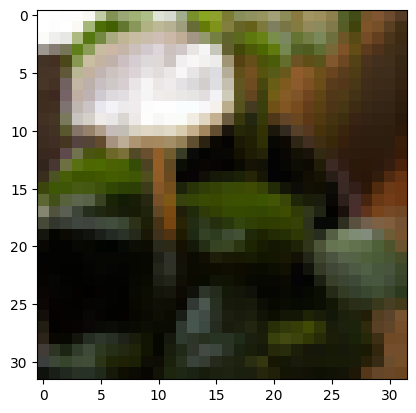

In [36]:
Selected_Image = 1002
image = X_train[Selected_Image]
plt.imshow(image)
plt.show()


## trymodel

## Pretrained

In [38]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
   rotation_range=40,
   width_shift_range=0.2,
   height_shift_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True,
   fill_mode='nearest')

# Fit the data generator to your data
train_data_generator.fit(X_train)

# Apply the transformations to your data
transformed_train_data = train_data_generator.flow(X_train,y_train, batch_size=32, shuffle=False)


In [39]:
test_data_generator = ImageDataGenerator()

transformed_test_data = test_data_generator.flow(X_test, y_test , batch_size = 32)

In [40]:


base_model = ResNet50(input_shape = (32,32,3) , include_top= False , weights= None,
    classes=100)

model = base_model.output
model = GlobalAveragePooling2D(name="avg_pool")(model)
model = BatchNormalization()(model)
model = Dropout(0.2, name="top_dropout")(model)
model = Dense(100 , activation="softmax", name="pred")(model)


pre_model = Model(inputs=base_model.input, outputs=x_newfc)


model.compile(optimizer= Adam(learning_rate=1e-2), loss="categorical_crossentropy", metrics=["accuracy"])


In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 top_dropout (Dropout)       (None, 2048)              0         
                                                                 
 pred (Dense)                (None, 100)               204900    
                                                                 
Total params: 23800804 (90.79 MB)
Trainable params: 23

In [ ]:
model.fit_generator(transformed_train_data,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=transformed_test_data,
    validation_steps=len(X_test) // 32
)

Epoch 1/50


<ipython-input-42-abf7457780af>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(transformed_train_data,


1562/1562 [==============================] - 81s 48ms/step - loss: 5.5014 - accuracy: 0.0271 - val_loss: 4.6636 - val_accuracy: 0.0289
Epoch 2/50
1562/1562 [==============================] - 73s 47ms/step - loss: 4.2588 - accuracy: 0.0497 - val_loss: 4.3529 - val_accuracy: 0.0647
Epoch 3/50
1562/1562 [==============================] - 73s 47ms/step - loss: 4.1729 - accuracy: 0.0677 - val_loss: 4.1959 - val_accuracy: 0.0760
Epoch 4/50
1562/1562 [==============================] - 74s 47ms/step - loss: 4.1257 - accuracy: 0.0757 - val_loss: 4.6062 - val_accuracy: 0.0688
Epoch 5/50
1562/1562 [==============================] - 73s 47ms/step - loss: 4.0596 - accuracy: 0.0875 - val_loss: 4.0267 - val_accuracy: 0.1071
Epoch 6/50
1562/1562 [==============================] - 75s 48ms/step - loss: 3.9736 - accuracy: 0.1025 - val_loss: 4.3905 - val_accuracy: 0.1025
Epoch 7/50
1562/1562 [==============================] - 74s 47ms/step - loss: 3.8999 - accuracy: 0.1108 - val_loss: 4.0885 - val_accura